<h1>Reptile</h1>
<h2>Imports and libraries</h2>
<p>These are the main imports for the reptile algorithm</p>

Code adapted from: https://keras.io/examples/vision/reptile/
Author: ADMoreau,
2020

In [4]:
import os

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds


os.environ['KMP_DUPLICATE_LIB_OK']='True' # Necessary due to running parallelisation on intel gpu

<h2>Define hyperparameters and meta-hyperparameters</h2>
<body>These are the relevant variables</body>
<ul> 

<b>Learning rate and step variables</b>
<li>Learning rate: The internal learning rate of the model</li>
<li>Meta step size: The learning rate of the meta-learning algorithm</li>

<b>Batch sizes</b>
<li>Inner batch size: The batch size used to for a single epoch of the inner model</li>
<li>Evaluation batch size: The batch size used for evaluating the inner model's progression</li>

<b>Iteration counters</b>
<li>:</li>
<li>:</li>
<li>:</li>

<b>Evaluation interval</b>
<li>Evalution interval: The number of episodes of the </li>

<b>Shots and classes</b>
<li>Training shots: The number of attempts used to adjust the inner model</li>
<li>Task shots: The number of attempts at classification the meta-learning algorithm can do</li>
<li>Classes: The number of differentiable classes used to identify the data</li>

</ul>

In [5]:
learning_rate = 0.05
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000 # 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1

train_shots = 20
shots = int(input("Please choose the number of shots: "))
classes = int(input("Please choose the number of classes: "))
datasetname = input("Please choose a dataset (imagenette/160px, omniglot, medical):").lower()

imagesize = int(input("Please enter image size:"))

splitstring = ""
if datasetname == "omniglot":
    splitstring = "test"
else:
    splitstring = "validation"

In [6]:


class CustomDataset:
    def __init__(self, training):
        # Define the directories and classes
        data_dir = 'C:/Users/dialg/Documents/Final_Year_Artefact/Datasets/Medical'
        class_names = ['benign', 'cancerous']

        # Create a list of file paths and their corresponding labels
        file_paths = []
        labels = []
        for i, class_name in enumerate(class_names):
            class_dir = os.path.join(data_dir, class_name)
            file_names = os.listdir(class_dir)
            class_file_paths = [os.path.join(class_dir, file_name) for file_name in file_names]
            file_paths.extend(class_file_paths)
            labels.extend([i] * len(class_file_paths))

        # Create TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

        # Define a function to preprocess the data
        def preprocess_image(file_path, label):
            # Load and preprocess the image
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=1)
            img = tf.image.resize(img, (imagesize, imagesize))  # Adjust the size as needed
            img = img / 255.0  # Normalize the pixel values between 0 and 1

            return img, label

        # Apply the preprocessing function to the dataset
        ds = dataset.map(preprocess_image)

        # Shuffle and batch the dataset
        batch_size = 1  # Adjust the batch size as needed
        dataset = dataset.shuffle(len(file_paths))
        dataset = dataset.batch(batch_size)
        
        self.data = {} # Empty dictionary created to hold data via label

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32) # Convert image to 32 tensorflow image
            image = tf.image.resize(image, [imagesize, imagesize]) # Resize to fit into input
            return image, label

        for image, label in ds.map(extraction): # For each image in the map of images
            image = image.numpy() # Image converted to numpy
            label = str(label.numpy()) # Label then created from string of the number

            if label not in self.data:
                self.data[label] = [] # Creates new empty dictionary definition at label

            self.data[label].append(image) # Data is appended with the correct label, appending tensor of the image
        self.labels = list(self.data.keys()) # Turns the labels into a list of keys
        
        for label in self.data.keys(): # label 0 
            startPointer = 0
            endPointer = 0
            if training:
                endPointer = len(self.data[label]) # 10000
                endPointer = int(endPointer * 0.8) # 8000
                startPointer = 0 # 0
            else:
                endPointer = len(self.data[label])
                startPointer = int(endPointer * 0.8)

            self.data[label] = self.data[label][startPointer:endPointer] #self.data[0] = self.data[0:8000]



    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, imagesize, imagesize, 1))

        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, imagesize, imagesize, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):

            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.

            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(self.data[label_subset[class_idx]], k=shots + 1)
                test_images[class_idx] = images_to_split[-1]
                temp_images[class_idx * shots : (class_idx + 1) * shots] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[class_idx * shots : (class_idx + 1) * shots] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices((temp_images.astype(np.float32), temp_labels.astype(np.int32)))
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            return dataset, test_images, test_labels
        
        return dataset

if datasetname == "medical":
    train_dataset = CustomDataset(training=True) # Split is decided by input variable
    test_dataset = CustomDataset(training=False)

In [7]:
class Dataset:
    def __init__(self, training):
        split = "train" if training else splitstring
        ds = tfds.load(datasetname, split=split, as_supervised=True, shuffle_files=False)
        
        self.data = {} # Empty dictionary created to hold data via label

        def extraction(image, label):
            # This function will shrink the Omniglot images to the desired size,
            # scale pixel values and convert the RGB image to grayscale
            image = tf.image.convert_image_dtype(image, tf.float32) # Convert image to 32 tensorflow image
            image = tf.image.rgb_to_grayscale(image) # Grayscale the image
            image = tf.image.resize(image, [imagesize, imagesize]) # Resize to fit into input
            return image, label

        for image, label in ds.map(extraction): # For each image in the map of images
            image = image.numpy() # Image converted to numpy
            label = str(label.numpy()) # Label then created from string of the number

            if label not in self.data:
                self.data[label] = [] # Creates new empty dictionary definition at label

            self.data[label].append(image) # Data is appended with the correct label, appending tensor of the image
        self.labels = list(self.data.keys()) # Turns the labels into a list of keys

    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, imagesize, imagesize, 1))

        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, imagesize, imagesize, 1))

        # Get a random subset of labels from the entire label set.
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):

            # Use enumerated index value as a temporary label for mini-batch in
            # few shot learning.
            temp_labels[class_idx * shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each
            # label to create the test dataset.

            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(self.data[label_subset[class_idx]], k=shots + 1)
                test_images[class_idx] = images_to_split[-1]
                temp_images[class_idx * shots : (class_idx + 1) * shots] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample the
                # necessary number of images.
                temp_images[class_idx * shots : (class_idx + 1) * shots] = random.choices(self.data[label_subset[class_idx]], k=shots)

        dataset = tf.data.Dataset.from_tensor_slices((temp_images.astype(np.float32), temp_labels.astype(np.int32)))
        dataset = dataset.shuffle(100).batch(batch_size).repeat(repetitions)

        if split:
            return dataset, test_images, test_labels
        
        return dataset



import urllib3
urllib3.disable_warnings()  # Disable SSL warnings that may happen during download.

if not datasetname == "medical":
    train_dataset = Dataset(training=True) # Split is decided by input variable
    test_dataset = Dataset(training=False)


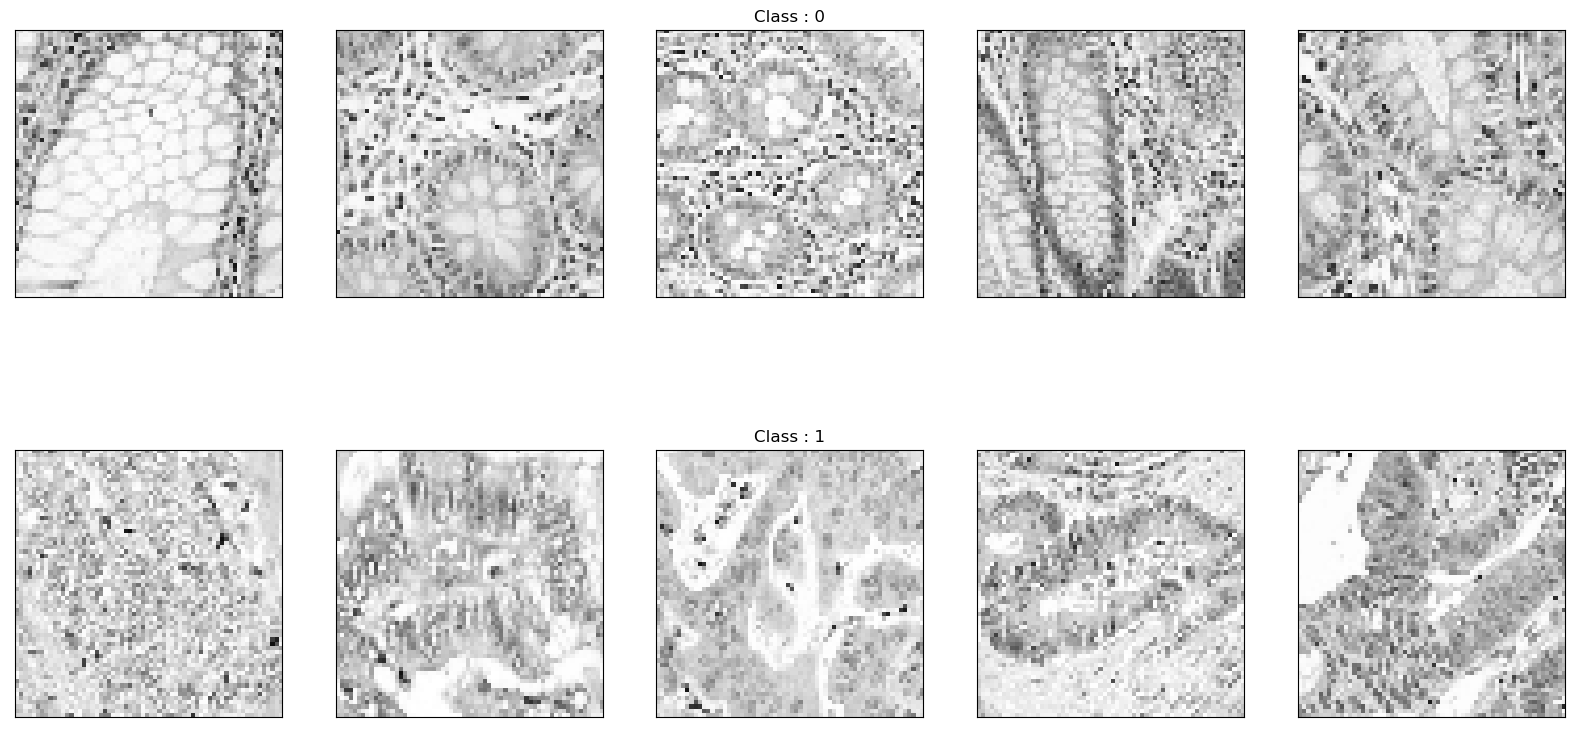

Done!


In [8]:
_, axarr = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

sample_keys = list(train_dataset.data.keys())

for a in range(2):
    for b in range(5):
        temp_image = train_dataset.data[sample_keys[a]][b]
        temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
        temp_image *= 255
        temp_image = np.clip(temp_image, 0, 255).astype("uint8")
        if b == 2:
            axarr[a, b].set_title("Class : " + sample_keys[a])
        axarr[a, b].imshow(temp_image)
        axarr[a, b].xaxis.set_visible(False)
        axarr[a, b].yaxis.set_visible(False)
plt.show()

In [9]:
def conv_bn(x): # Define a function for simple convolutional layers
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x) # Can be called upon itslef


inputs = layers.Input(shape=(imagesize, imagesize, 1)) #Define input layer shape

x = conv_bn(inputs) # Convolutional layer created using inpu
x = conv_bn(x) # Repeatedly called to create a convolutional network
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x) # Flatterns out shape of hidden layer

outputs = layers.Dense(classes, activation="softmax")(x) # Outputs defined with softmax activation instead of ReLU

model = keras.Model(inputs=inputs, outputs=outputs) # Model is created
model.compile() # Model is compiled

optimizer = keras.optimizers.SGD(learning_rate=learning_rate) # Optimised with learning rate set

In [10]:
training = []
testing = []

for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size

    # Temporarily save the weights from the model.
    old_vars = model.get_weights()

    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(inner_batch_size, inner_iters, train_shots, classes)

    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)

        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

    new_vars = model.get_weights()

    # Perform SGD for the meta step.
    for var in range(len(new_vars)): 
        new_vars[var] = old_vars[var] + ((new_vars[var] - old_vars[var]) * cur_meta_step_size)

    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)

    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []

        for dataset in (train_dataset, test_dataset): # Done for each dataset
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(eval_batch_size, eval_iters, shots, classes, split=True) # Gets a minidataset using the evaluation batch size and iterators.

            old_vars = model.get_weights() # Older weights stored

            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set: # Get images and labels in training set
                with tf.GradientTape() as tape:
                    preds = model(images) # Predict through passing in images in
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds) # Categorical cross entropy loss used to monitor loss

                grads = tape.gradient(loss, model.trainable_weights) 
                optimizer.apply_gradients(zip(grads, model.trainable_weights)) # Optimiser applies the gradients to the weights that can be updated

            test_preds = model.predict(test_images) # Predict on test images
            test_preds = tf.argmax(test_preds).numpy() # Get predictions as numpy array
            num_correct = (test_preds == test_labels).sum() # Get the sum of the number of correct classification

            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars) # Revert to older weights to prevent training while harvesting data
            accuracies.append(num_correct / classes) # Add the accuracy relative to the number of classes

        training.append(accuracies[0]) # Add Training accuracy
        testing.append(accuracies[1]) # Add Testing accuracy

        if meta_iter % 100 == 0: # Print out batch and information ever 100 interations
            print("batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1]))

1/1 [==============================] - 0s 22ms/step
batch 0: train=0.250000 test=0.000000
1/1 [==============================] - 0s 25ms/step


: 

: 

1/1 [==============================] - 0s 38ms/step
4


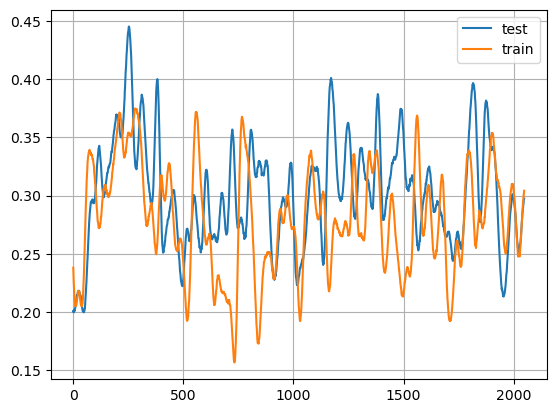

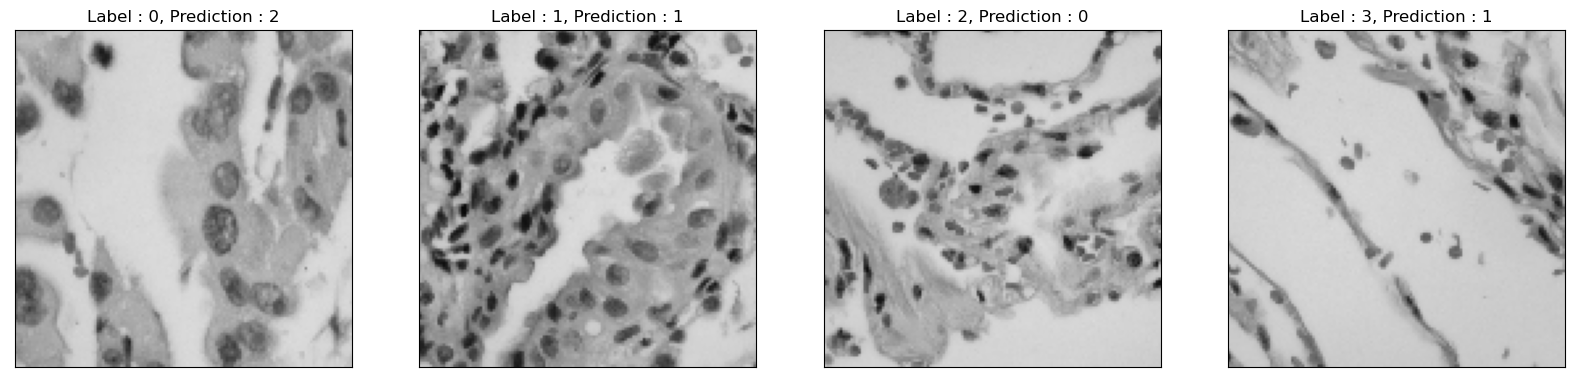

In [ ]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 50 # Lower increases the number of turning points in the curve
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()

train_set, test_images, test_labels = dataset.get_mini_dataset(
    eval_batch_size, eval_iters, shots, classes, split=True
)
for images, labels in train_set:
    with tf.GradientTape() as tape:
        preds = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
test_preds = model.predict(test_images)
test_preds = tf.argmax(test_preds).numpy()

_, axarr = plt.subplots(nrows=1, ncols=classes, figsize=(20, 20))

sample_keys = list(train_dataset.data.keys())
print(len(test_images))

for i, ax in zip(range(5), axarr):
    temp_image = np.stack((test_images[i, :, :, 0],) * 3, axis=2)
    temp_image *= 255
    temp_image = np.clip(temp_image, 0, 255).astype("uint8")
    ax.set_title(
        "Label : {}, Prediction : {}".format(int(test_labels[i]), test_preds[i])
    )
    ax.imshow(temp_image, cmap="gray")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.show()

In [ ]:
def checkModelNum(path):
        file = open(path, 'r')
        lines = file.read()
        if len(lines) > 1:
            allAccuracies = []
            allAccuracies = lines.split(",")
            number = allAccuracies[-1].split('_')
            return (int(number[-1]))
        else:
            return 0

In [ ]:
def getAccuracy():
    correct = 0
    total = 0
    for i in range(len(test_preds)):
        if test_preds[i] == test_labels[i]:
            correct += 1
        total += 1
    return correct/total

In [ ]:
def saveAccuracies(filePath, curModelNum):
    if not os.path.exists(filePath):
        print("Accuracy file not found.")
        print('Saving accuracies to file...')
        file = open(filePath, 'w+')
        file.write(f',{str(getAccuracy())}_{curModelNum}')
        file.close()
    else:
        print("Accuracy file found, saving.")
        file = open(filePath, 'a')
        file.write(f',{getAccuracy()}_{curModelNum}')
        file.close()



In [ ]:
def appendToCSV(path, columnName):
    if os.path.exists(path):
        # CSV file exists, append number 0
        df = pd.DataFrame({columnName : [str(getAccuracy())]})
        df.to_csv(path, mode='a', index=True)
        print("Number appended to existing CSV file.")
    else:
        # CSV file doesn't exist, create a new one
        df = pd.DataFrame({columnName: [str(getAccuracy())]})
        df.to_csv(path, index=True)
        print("CSV file created.")

In [ ]:
def saveTrainingCSV(csvPath, curModelNum):
    if not os.path.exists(f'{csvPath}/Test'):
        os.mkdir(f'{csvPath}/Test')
        print("Test folder made.")
    if not os.path.exists(f'{csvPath}/Train'):
        os.mkdir((f'{csvPath}/Train'))
        print("Train folder made.")


    if not os.path.exists(f'{csvPath}/{curModelNum}.csv'):
        print("Creating CSV.")
        df = pd.DataFrame(train_s, columns=['Training Accuracies'])
        df.to_csv(f'{csvPath}/Train/{curModelNum}.csv')
        df = pd.DataFrame(test_s, columns=['Training Accuracies'])
        df.to_csv(f'{csvPath}/Test/{curModelNum}.csv')
    else:
        print("CSV found.")

In [ ]:
def saveModel(path):
    model.save(path)

In [ ]:
def getRootDir():
    wd = os.getcwd()
    saver = 0
    for i, directory in enumerate(wd.split("\\")):
        if directory == "Final_Year_Artefact":
            saver = i
            saver +=1
    rootSections = wd.split("\\")[:saver]

    root = ""
    for i, string in enumerate(rootSections):
            root += string + "/"
    return root


In [ ]:
if datasetname == "imagenette/160px":
    pathDir = "imagenette_160px"
else:
    pathDir = datasetname
modelName = "Reptile"
root = getRootDir() + 'Data/'
path = f'{root}/Statistics/Accuracies/{modelName}/{pathDir}_{classes}_{shots}_Accuracies'
csvPath = f'{root}/Statistics/Graphs/{modelName}/{pathDir}_{classes}_{shots}'

filePath = path + '/Accuracies.txt'


if not os.path.exists(path):
    print("Folder not found, creating folder.")
    os.makedirs(path)
else:
    print("Folder found.")

if not os.path.exists(csvPath):
    print("CSV folder not found, creating folder.")
    os.makedirs(csvPath)
else:
    print("CSV folder found.")

if not os.path.exists(filePath):
    print("No accuracy file found.")
    print("Creating accuracy file.")
    fileMaker = open(filePath, "w+")
    fileMaker.close()
else:
    print("Accuracy file found, skipping creation.")


currentModelNum = checkModelNum(filePath) + 1

modelPath = f'{root}/Models/{modelName}/{pathDir}_{classes}_{shots}/{currentModelNum}'

saveAccuracies(filePath, currentModelNum)
saveTrainingCSV(csvPath, currentModelNum)
saveModel(modelPath)


Folder found.
CSV folder found.
Accuracy file found, skipping creation.
Accuracy file found, saving.
Creating CSV.


INFO:tensorflow:Assets written to: c:/Users/dialg/Documents/Final_Year_Artefact/Data//Models/Reptile/medical_4_5/4\assets


INFO:tensorflow:Assets written to: c:/Users/dialg/Documents/Final_Year_Artefact/Data//Models/Reptile/medical_4_5/4\assets
